# Congestion multipliers

Is there a way we can proxy for congestion, and find out what hours of the day are more prone to congestion? 

We take a proxy by considering the NYC speed limit of 25mph (although, it is slower in certain sections), taking the time taken to travel the *Euclidean distance*, and then finding out the excess time each trip takes is. Of course, this will be quite variant, as cars don't travel in straight lines from point A to point B, but the hope is that across a wide enough data set, the mean response shows a trend in congestion.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict
from scipy.stats import zscore

### The feature

For two geographic points given by `(latitude, longitude)`, we can find the distance between the two in miles (or kilometres) by using the Harversine formula.
From this, the sub-feature we are creating simply divides the distance given by the Harversine formula by 0.007 (25 mph in miles/second), to get the time taken to drive the Euclidean distance. 
Then, our feature is the difference between the trip time and the euclidean distance time; or:

    `congestion = trip time - euclidean time`

In [13]:
from math import radians, cos, sin, asin, sqrt

def get_congestion(row):
    # Taken from https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    def haversine(lon1, lat1, lon2, lat2):
        """
        Calculate the great circle distance in kilometers between two points 
        on the earth (specified in decimal degrees)
        """
        # convert decimal degrees to radians 
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

        # haversine formula 
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a)) 
        r = 3956 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
        return c * r
    
    miles_per_second = 0.007
    euclidean_dist = haversine(row['pickup_longitude'], row['pickup_latitude'], row['dropoff_longitude'], row['dropoff_latitude'])
    euclidean_trip_time = euclidean_dist / miles_per_second

    return row['trip_time_in_secs'] - euclidean_trip_time

Now our gathering of locations is not *perfect* - the geolocator is not an extremely precise tool, and has misinterpreted some places as being out of New York City entirely. So we will ignore any data points with `congestion < 0`, as these will not be helpful for our analysis.

#### An example

In [4]:
example_data = pd.read_parquet('../data/tr_data/2009-01.parquet')

In [5]:
example_data['congestion'] = example_data.apply(get_congestion, axis=1)
congestion_data = example_data[example_data['congestion'] > 0].copy()

Text(0.5, 1.0, 'Distribution of congestion times')

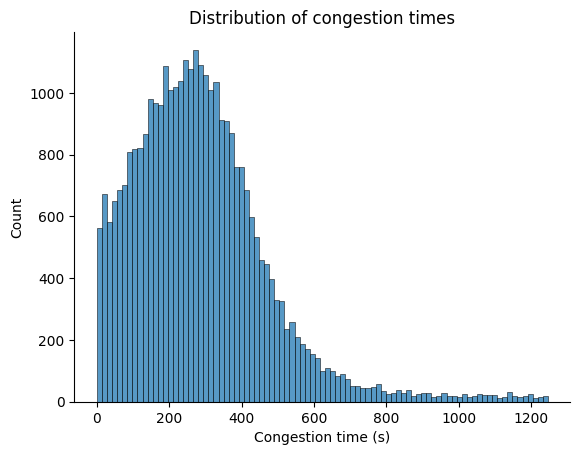

In [6]:
sns.histplot(congestion_data['congestion'])
sns.despine()
plt.xlabel('Congestion time (s)')
plt.title('Distribution of congestion times')

Grouping by time of the day, we can consider when congestion times are the longest.

Text(0.5, 1.0, 'Mean congestion times across the day')

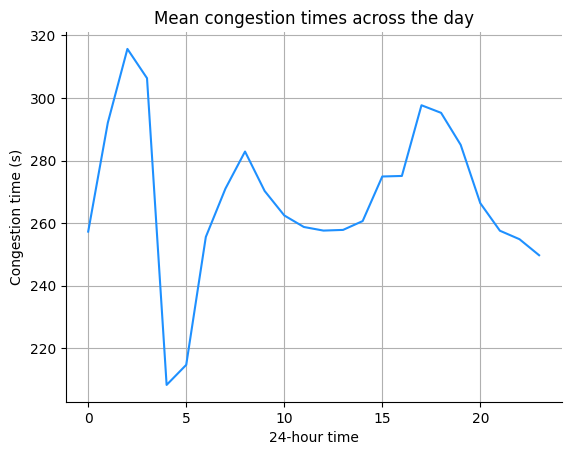

In [8]:
congestion_data['hour'] = congestion_data['pickup_datetime'].dt.hour
hour_by_congestion = congestion_data.groupby('hour')['congestion'].median()

plt.plot(hour_by_congestion.index, hour_by_congestion, color='dodgerblue')
sns.despine()
plt.grid()
plt.xlabel('24-hour time')
plt.ylabel('Congestion time (s)')
plt.title('Mean congestion times across the day')

### Making a theoretical congestion surcharge model

We can make a theoretical congestion surcharge model by drawing a mean line and then taking fluctuations above and below the mean line to be multipliers of price.

In [ ]:
data_list = []

date_ptr = '2009-01'

while date_ptr != '2024-01':
    date_data = pd.read_parquet(f'../data/tr_data/{date_ptr}.parquet')
    data_list.append(date_data)
    date_ptr = (pd.to_datetime(date_ptr) + pd.DateOffset(months=1)).strftime('%Y-%m')

all_df = pd.concat(data_list)
all_df['congestion'] = all_df.apply(get_congestion, axis=1)

#### Visualising the distribution of congestions

In [20]:
no_neg = all_df[all_df['congestion'] > 0].copy()

Text(0.5, 0, 'Theoretical congestion time (s)')

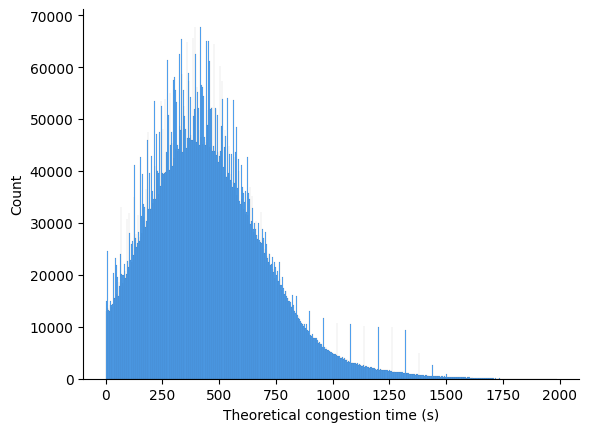

In [60]:
sns.histplot(no_neg['congestion'], color='dodgerblue')
sns.despine()
plt.xlabel('Theoretical congestion time (s)')

We see some unusual peakts at specific congestion times; which I theorise is due to rounding of minutes for some of the data.

#### By hour congestion

In [22]:
no_neg['hour'] = no_neg['pickup_datetime'].dt.hour

Text(0.5, 1.0, 'Mean congestion times across 2009-2024')

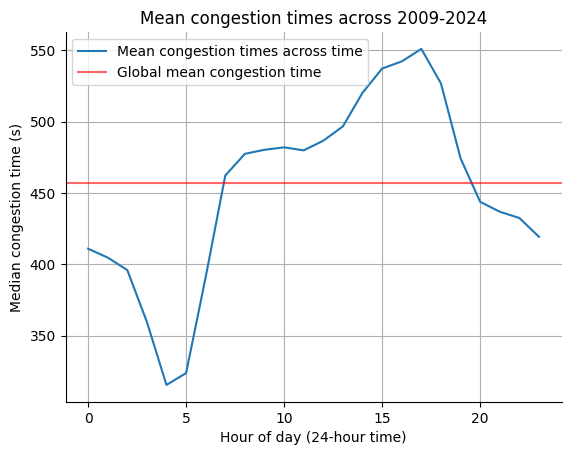

In [55]:
groupby_hour_congestion = no_neg.groupby('hour')['congestion'].mean()
mean_congestion = no_neg['congestion'].mean()
plt.plot(groupby_hour_congestion.index, groupby_hour_congestion, label='Mean congestion times across time')
plt.axhline(mean_congestion, color='red', alpha=0.6, label='Global mean congestion time')
plt.grid()
sns.despine()
plt.xlabel('Hour of day (24-hour time)')
plt.ylabel('Median congestion time (s)')
plt.legend()
plt.title('Mean congestion times across 2009-2024')

#### Trying to make a transformation to create multipliers

Our initial theoretical model will be using adjusted $z$-score. Consider a $z$-score $x$, and our theoretical congestion multiplier $s$, then our congestion multiplier is $s = 1 + x$.
A few notes:
- $x$ can obviously be $< 0$, but we'll discuss this after we calculate an example of the global congestion multiplier
- $x$ could become very large, 


Let us plot this for the global data and see how large our multipliers get

Text(0.5, 1.0, 'First iteration of congestion multiplier')

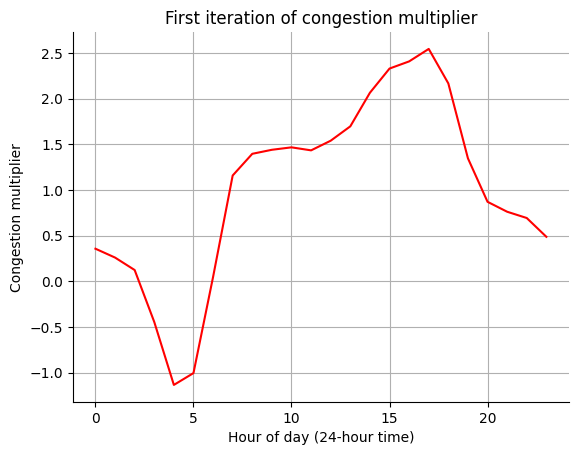

In [61]:
from scipy.stats import zscore

zscores = zscore(groupby_hour_congestion)
congestions = 1 + zscores


plt.plot(congestions, color='red')
plt.grid()
sns.despine()
plt.xlabel('Hour of day (24-hour time)')
plt.ylabel('Congestion multiplier')
plt.title('First iteration of congestion multiplier')

But giving riders a discount for *less* congestion is not standard industry practice. We also see a peak multiplier of 2.5x, which is pretty large. We squash the $z$-scores > 0 between $(0, 1)$ using a sigmoid transformation; we wish to restrict multipliers to 2x to avoid large multipliers.

In [74]:
negative_congestion_flattened = [0 if i < 0 else i for i in zscores]
sigmoid_correction = [0 if 1 / (1 + np.exp(-i)) == 0.5 else 1 / (1 + np.exp(-i)) for i in negative_congestion_flattened]
congestion_multipliers = 1 + np.array(sigmoid_correction)

Text(0.5, 1.0, 'Final congestion surcharge model')

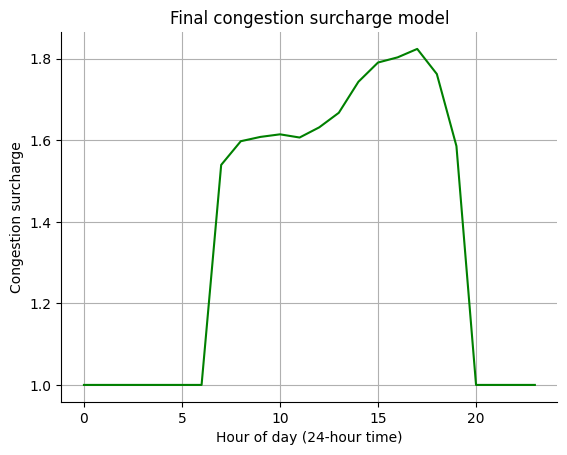

In [81]:
plt.plot(congestion_multipliers, color='green')
plt.grid()
sns.despine()
plt.xlabel('Hour of day (24-hour time)')
plt.ylabel('Congestion surcharge')
plt.title('Final congestion surcharge model')

### How often should we update?

How stable are the congestion surcharges? Should we update every year, or is a global congestion surcharge model enough?

In [8]:
year_data_dict = defaultdict(list)

date_ptr = '2009-01'

while date_ptr != '2024-01':
    date_ptr_dt = pd.to_datetime(date_ptr)
    year = date_ptr_dt.year
    month = date_ptr_dt.strftime('%B')
    
    date_data = pd.read_parquet(f'../data/tr_data/{date_ptr}.parquet')
    year_data_dict[year].append(date_data)
    date_ptr = (pd.to_datetime(date_ptr) + pd.DateOffset(months=1)).strftime('%Y-%m')

In [15]:
def congestion_multipliers(data: pd.DataFrame):
    data['congestion'] = data.apply(get_congestion, axis=1)
    no_neg = data[data['congestion'] > 0].copy()
    no_neg['hour'] = no_neg['pickup_datetime'].dt.hour
    groupby_congestion = no_neg.groupby('hour')['congestion'].mean()
    zscores = zscore(groupby_congestion)

    negative_congestion_flattened = [0 if i < 0 else i for i in zscores]
    sigmoid_correction = [0 if 1 / (1 + np.exp(-i)) == 0.5 else 1 / (1 + np.exp(-i)) for i in negative_congestion_flattened]
    congestion_multipliers = 1 + np.array(sigmoid_correction)
    return congestion_multipliers

In [18]:
year_congestion = defaultdict()

for year, data in year_data_dict.items():
    year_data = pd.concat(data)
    year_data['congestion'] = year_data.apply(get_congestion, axis=1)
    year_congestion[year] = congestion_multipliers(year_data)

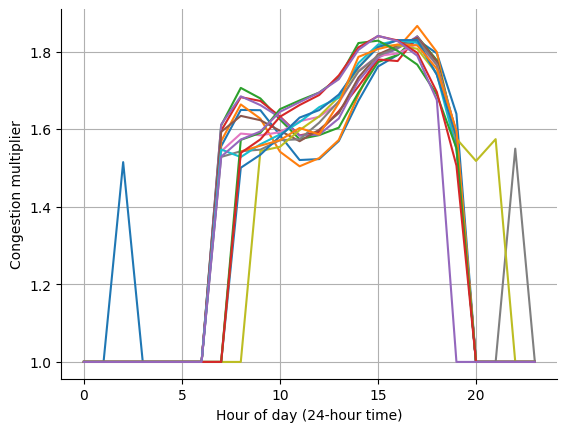

In [22]:
for year, congestion in year_congestion.items():
    plt.plot(congestion, label=year)
    plt.xlabel('Hour of day (24-hour time)')
    plt.ylabel('Congestion multiplier')
    sns.despine()
    plt.grid()

plt.show()

It appears to be approximately the same distribution across 2009 - 2024. Furthermore, restricting to certain days introduces outliers early in the day with congestion multipliers, which is undesirable. Thus, we will use the entire data set instead of something like a 1-year lookback.